## Problem 2

### Import our data and plot some metrics to get a feel for the dataset

[Text(0.5, 1.0, 'Resting BP v Age')]

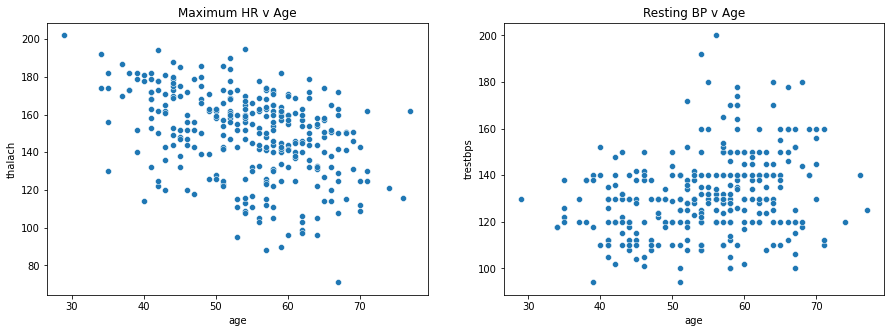

In [11]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

# read data
heart_data = pd.read_csv('data/heart.csv')

# create axes
fig, ax = plt.subplots(1,2, figsize=(15,5))

# plot Maximum HR as a function of age
sns.scatterplot(
    ax=ax[0],
    data=heart_data, 
    x="age",
    y="thalach",
).set(title="Maximum HR v Age")

# plot Resting BP as a function of age
sns.scatterplot(
    ax=ax[1],
    data=heart_data, 
    x="age",
    y="trestbps",
).set(title="Resting BP v Age")

Using the `sklearn` package, lets fit a multilinear regression model to the data:

In [12]:
from sklearn import linear_model

# init the regression class
regr = linear_model.LinearRegression()

X = heart_data[['trestbps', 'age', 'chol']]
Y = heart_data['thalach']

# fit data to multilinear regression
regr.fit(X, Y)

# print out our coefficients
print(f"Regression intercept: {regr.intercept_}")
print(f"Regression coeffs: {regr.coef_}")
print(f"Regression r^2: {regr.score(X,Y)}")
print(f"Equation: MaxHR = {round(regr.intercept_,2)} + X1*{round(regr.coef_[0],2)} + X2*{round(regr.coef_[1],2)} + X3{round(regr.coef_[2],2)}, where X1 = Resting BP, X2 = Age, and X3 = Cholesterol level")

Regression intercept: 189.68457189894912
Regression coeffs: [ 0.08485324 -1.09099419  0.03291974]
Regression r^2: 0.16862175072703345
Equation: MaxHR = 189.68 + X1*0.08 + X2*-1.09 + X30.03, where X1 = Resting BP, X2 = Age, and X3 = Cholesterol level


We can now predict a patients maximum heart rate based on their resting blood pressure and their age:

In [13]:
maxHR = regr.predict([[
    145, # trestbps
    63, # age
    233 # chol
]])

print(f"Predicted max heart rate: {round(maxHR[0])} bps")

Predicted max heart rate: 141 bps


I took the first datapoint out of our sample with the following parameters:

- Resting bloo pressure: 145 mmHg
- Age: 63 yr-old
- Cholesterol: 233 mg/dL

Plugging those into our model, we get a predicted maximum heart rate of **141 bps**. This is not too far off from the actual value of 150 bps.

We can calculate the error (or residuals) for the rest of our data as such:

In [14]:
residuals = [
    row['thalach'] - regr.predict([[
       row['trestbps'],
       row['age'],
       row['chol']
    ]])[0] for (_, row) in heart_data.iterrows()
]

Plot the residuals against our predictor values

Text(0.5, 1.0, 'Residuals against Resting Cholesterol level')

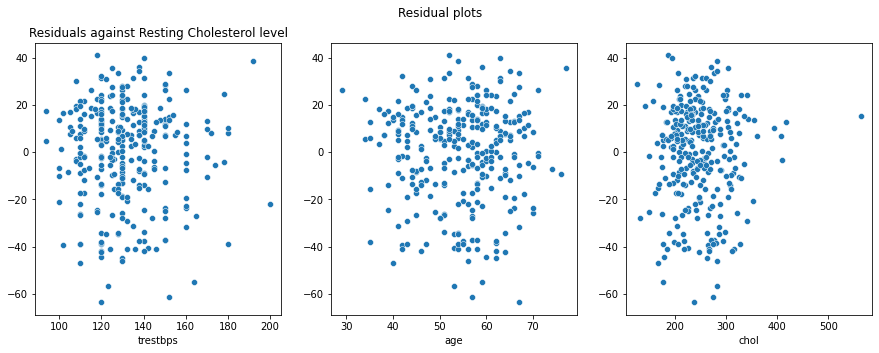

In [15]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Residual plots')

# plot resting BP residuals
sns.scatterplot(ax=ax[0], x=heart_data['trestbps'], y=residuals)
ax[0].set_title('Residuals against Resting BP')

# plot resting age residuals
sns.scatterplot(ax=ax[1], x=heart_data['age'], y=residuals)
ax[0].set_title('Residuals against Resting age')

# plot resting chol residuals
sns.scatterplot(ax=ax[2], x=heart_data['chol'], y=residuals)
ax[0].set_title('Residuals against Resting Cholesterol level')


## Problem 3
A classic example of data to which we can fit an exopential is daily new case counts during the coronavirus pandemic. I happen to have case counts for the state of Indiana. I extracted out cases between the dates **September 22nd, 2020** and **November 25th, 2020** in order to avoid the "waves" we have seen.

Lets look at the data:

([<matplotlib.axis.XTick at 0x13501ddf0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

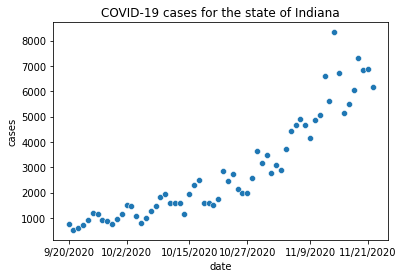

In [16]:
# read in the data
covid_data = pd.read_csv('data/covid.csv')

# plot the data
sns.scatterplot(
    data=covid_data,
    x="date",
    y="cases"
).set(title="COVID-19 cases for the state of Indiana")

# create some tick lables
indices = [round(i) for i in np.linspace(0, len(covid_data['cases'])-2, num=6)]
plt.xticks([covid_data['date'][i] for i in indices])


To fit an exponential lets linearize the data and fit it to a linear regression

<AxesSubplot:xlabel='days', ylabel='logcases'>

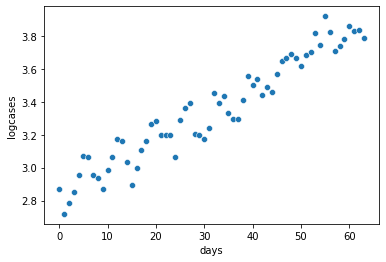

In [17]:

from datetime import datetime
date_format = "%m/%d/%Y"

day_zero = datetime.strptime('09/20/2020', date_format)

# linearize data
covid_data['logcases'] = np.log10(covid_data['cases'])

# init a new column
covid_data['days'] = np.zeros(len(covid_data))
covid_data['days'] = [(datetime.strptime(row['date'], date_format) \
    - day_zero).days for (_, row) in covid_data.iterrows()]

# plot to show linear relationship
sns.scatterplot(
    data=covid_data,
    x="days",
    y="logcases"
)


Now we can fit a linear regression to our data and extract out parameters after linearizing the data

In [18]:
# init the regression class
covid_lin_regr = linear_model.LinearRegression()

# extract data to fit
X = covid_data[['days']]
y = covid_data['logcases']

# fit
covid_lin_regr.fit(X, y)

# extract params
print(f"Intercept: {covid_lin_regr.intercept_}")
print(f"Slope: {covid_lin_regr.coef_[0]}")

Intercept: 2.8330092724282654
Slope: 0.016452348797853567


We know from the linearized version of the exponential equation $y=ab^{x}$, that with our linearized model we can get the original params a and b:

**$a = 10^{intercept}$** and **$b=10^{slope}$**

We can then plot our new exponential function to see how it fits our original data.

Text(0, 0.5, 'Cases')

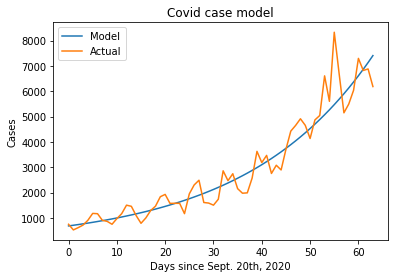

In [19]:
# calc original params
a = 10**covid_lin_regr.intercept_
b = 10**covid_lin_regr.coef_[0]

# create model
def covid_model(x: int, a:float, b:float) -> float:
    return a*b**x

# generate some data and plot against original
# data we saw before
y_pred = [round(covid_model(x, a, b)) for x in covid_data['days']]
plt.plot(covid_data['days'], y_pred)
plt.plot(covid_data['days'], covid_data['cases'])
plt.legend(['Model', 'Actual'])
plt.title('Covid case model')
plt.xlabel('Days since Sept. 20th, 2020')
plt.ylabel('Cases')


## Problem 4
I will be using a picture of my cat to run the omage iterpolation code. We need to decimate it all at 3 different levels.

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

DIM = 4000
DECIMATION_FACTOR = 80

# load in image and convert to grayscale and crop
cat = plt.imread('data/karen.png')
cat = np.dot(cat[..., :3], [0.299, 0.587, 0.114])
cat = cat[:DIM,:DIM] # crop image

# create the sparse image
cat_sparse = np.zeros((int(DIM/DECIMATION_FACTOR), int(DIM/DECIMATION_FACTOR)))

# init the figure and axes objects
fig, ax = plt.subplots(1,3, figsize=(12,8))

# plot the original
ax[0].imshow(cat, cmap="gray")
ax[0].set_title("Original Image")

We need to extract the shape of our image now to run the decimation

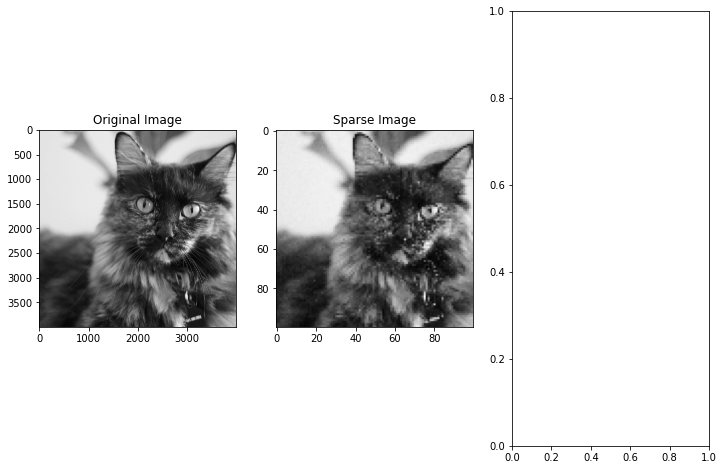

In [82]:
# decimate the image
for i in range(int(DIM/DECIMATION_FACTOR)):
    for j in range(int(DIM/DECIMATION_FACTOR)):
        cat_sparse[i,j] = cat[i*DECIMATION_FACTOR][j*DECIMATION_FACTOR]

ax[1].imshow(cat_sparse, cmap='gray')
ax[1].set_title("Sparse Image")
fig

Lets now run an interpolation for the image to "smooth it back"


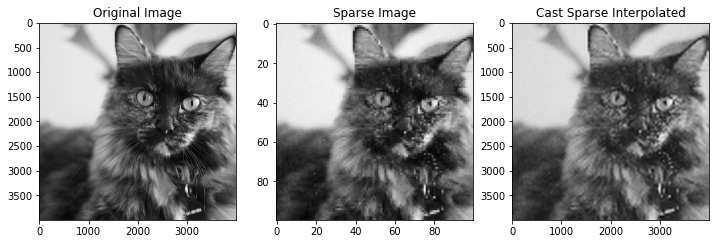

In [83]:
# Interpolate
Xi, Yi = np.arange(0, DIM, 1), np.arange(0, DIM, 1)
X, Y = np.arange(0, DIM, DECIMATION_FACTOR), np.arange(0, DIM, DECIMATION_FACTOR)

f = interpolate.interp2d(X, Y, cat_sparse, kind='cubic')
cat_sparse_i = f(Xi, Yi)

ax[2].imshow(cat_sparse_i, cmap="gray")
ax[2].set_title('Cat Sparse Interpolated')
fig

## Problem 5
Using an already written optimization algorithm in the `scipy` package, we can verify the result obtained from the hand-calculations:

In [22]:
from scipy import optimize

# define function to optimize
def f(x):
    return (x[0]**2) + (2*(x[1]**2)) - x[0] - (6*x[1])

optimize.fmin(f, [0,0])

Optimization terminated successfully.
         Current function value: -4.750000
         Iterations: 63
         Function evaluations: 120


array([0.50001601, 1.50002605])

## Problem 9
The Newton-Raphson's algorithm I wrote for the in-class problem can be found in the `nr.py` file. I'm running the optimization on the **Hill function**:

$$
\dfrac{Ax^{n}}{x^{n} + k^{n}}
$$


In [23]:
from nr import *

root = newton_raphson(hill, 1.5)
print(f"The root was found to be: {round(root,2)}")

The root was found to be: 1.36


## Problem 10
The code that implements the Golden Section Search algorithm is found in the `gss.py` file. To demonstrate this function, I am going to try to maximize the function:

$$
f(x) = \dfrac{10}{x}sin(x)
$$

In [24]:
from gss import *
 
# implement gss algorithm
maximum = gss(f, 7, 9)
print(f"Maximum found: {round(maximum, 2)}")

Maximum found: 7.73
